## Imports
Here we will do our usual imports. I would recommend numpy, scipy, skimage, sklearn, pytorch, and matplotlib. If you wish to utilise pointcloud visualisation then you can do that as described in the handout via Open3D. We will want to import our PacMan_Helper module as well.

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import copy
from lib import PacMan_Helper_Accelerated as PacMan

### Check GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    print(f'Using GPU: {gpu_name}')
else:
    print('CUDA is not available, using CPU.')

Using GPU: NVIDIA GeForce RTX 3070


## Load the training data: Positives and Negatives
In the handout zip file there is a directory which contains numerous patches extracted from sample images. These patches are labelled as either containing a sphere or not. You may wish to use these to train a classifier for sphere detection. This classifier can then be used later to detect spheres and move our camera towards them.

In [3]:
class PacmanDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Initialise data set
        :param root_dir: file path which contains 'positives' and 'negatives' 
        :param transform: the transformation operation to be applied to each image
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Load positives
        pos_dir = os.path.join(root_dir, 'positives')
        self.images += [os.path.join(pos_dir, file) for file in os.listdir(pos_dir)]
        self.labels += [1] * len(os.listdir(pos_dir))  # 1 for positives

        # Load negatives
        neg_dir = os.path.join(root_dir, 'negatives')
        self.images += [os.path.join(neg_dir, file) for file in os.listdir(neg_dir)]
        self.labels += [0] * len(os.listdir(neg_dir))  # 0 for negatives

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation
])

In [5]:
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random flip
    # Specific rotations to augment dataset
    transforms.RandomChoice([
        transforms.RandomRotation((90, 90)),
        transforms.RandomRotation((180, 180)),
        transforms.RandomRotation((270, 270))
    ]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation
])

In [6]:
# Create data-set
dataset = PacmanDataset(root_dir='training_data/img')

# Initialise the size of datasets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Divided into three datasets
train_val_indices, test_indices = train_test_split(range(len(dataset)), test_size=test_size, stratify=dataset.labels)
train_indices, val_indices = train_test_split(train_val_indices, test_size=val_size / (val_size + train_size), stratify=[dataset.labels[i] for i in train_val_indices])

train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)
test_subset = torch.utils.data.Subset(dataset, test_indices)

train_dataset = PacmanDataset(root_dir='training_data/img', transform=transform_augmented)
train_dataset.images = [train_subset.dataset.images[i] for i in train_indices]
train_dataset.labels = [train_subset.dataset.labels[i] for i in train_indices]

val_dataset = PacmanDataset(root_dir='training_data/img', transform=transforms.ToTensor())
val_dataset.images = [val_subset.dataset.images[i] for i in val_indices]
val_dataset.labels = [val_subset.dataset.labels[i] for i in val_indices]

test_dataset = PacmanDataset(root_dir='training_data/img', transform=transforms.ToTensor())
test_dataset.images = [test_subset.dataset.images[i] for i in test_indices]
test_dataset.labels = [test_subset.dataset.labels[i] for i in test_indices]

# Create data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Check the data leakage

In [7]:
def check_for_leakage(train_data, val_data, test_data):
    # Get the full list of image paths for each dataset 
    train_set = set(train_data.images)
    val_set = set(val_data.images)
    test_set = set(test_data.images)

    # Check for overlap 
    train_val_overlap = train_set.intersection(val_set)
    train_test_overlap = train_set.intersection(test_set)
    val_test_overlap = val_set.intersection(test_set)

    # Print the results
    print(f"Train/Validation overlap: {len(train_val_overlap)} images")
    print(f"Train/Test overlap: {len(train_test_overlap)} images")
    print(f"Validation/Test overlap: {len(val_test_overlap)} images")

    # Return True if there's any overlap, indicating leakage
    leakage = len(train_val_overlap) > 0 or len(train_test_overlap) > 0 or len(val_test_overlap) > 0
    return leakage

In [8]:
# run the leakage check
leakage_detected = check_for_leakage(train_dataset, val_dataset, test_dataset)
if leakage_detected:
    print("Data leakage detected!")
else:
    print("No data leakage detected.")

Train/Validation overlap: 0 images
Train/Test overlap: 0 images
Validation/Test overlap: 0 images
No data leakage detected.


### Showing examples in data loader

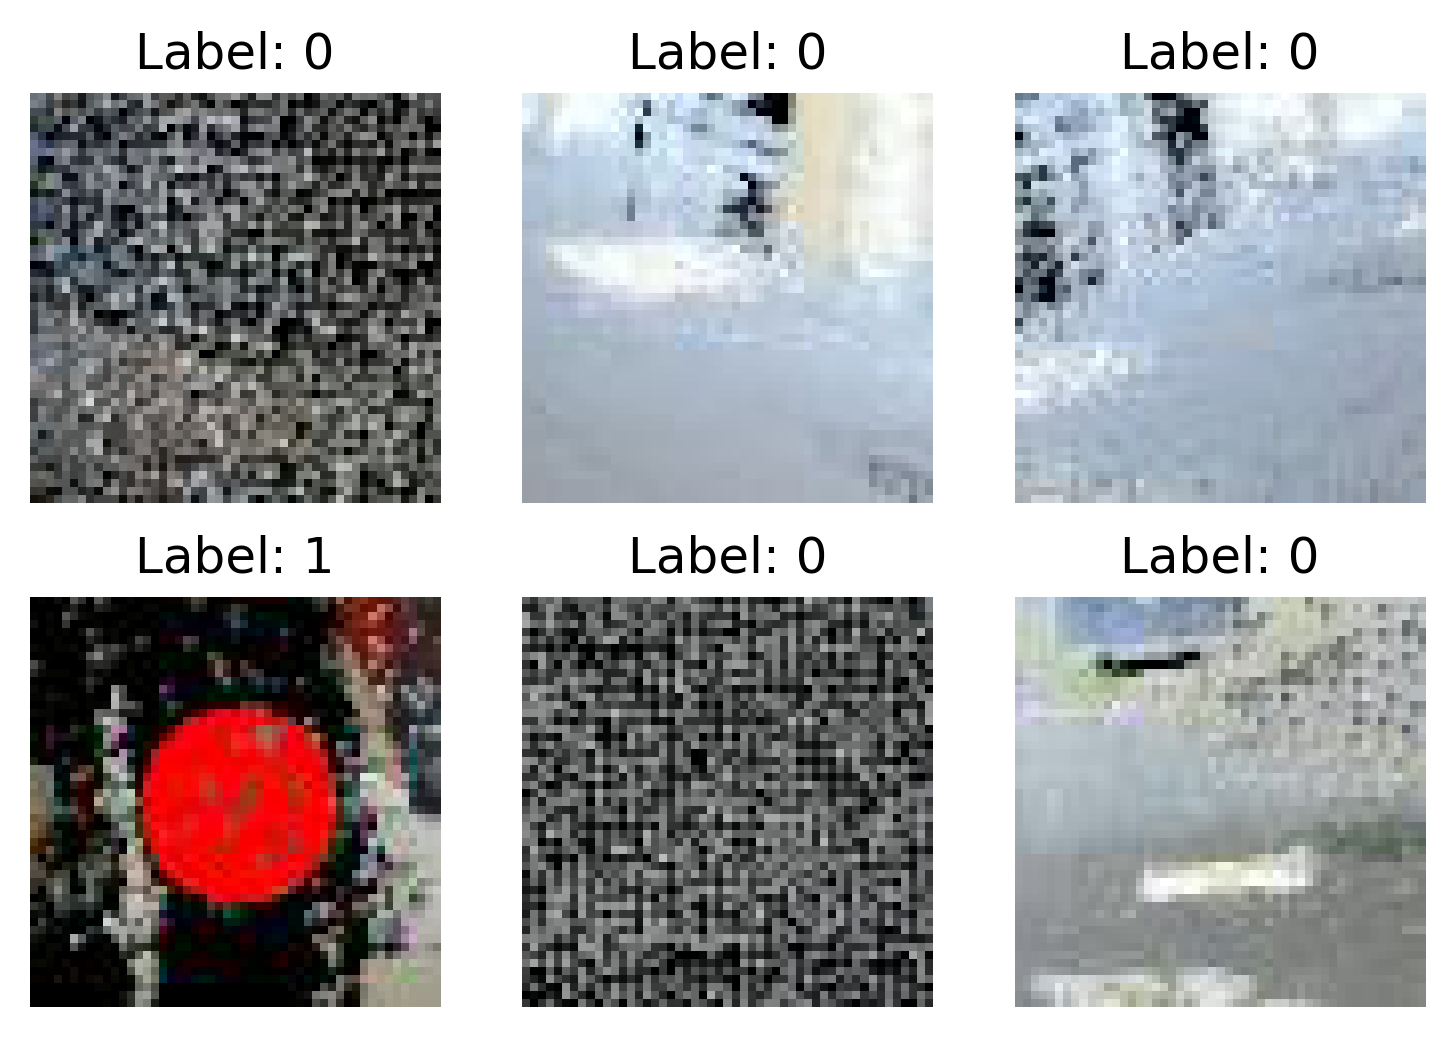

In [9]:
# get a batch size of data from data loader
images, labels = next(iter(train_loader))

# plot 6 examples in data loader
fig, axs = plt.subplots(2, 3, figsize=(6, 4), dpi = 300)

for i, ax in enumerate(axs.flat):
    # convert tensor to numpy
    img = images[i].numpy().transpose((1, 2, 0))
    
    # denormalise images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # plot
    ax.imshow(img)
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')

plt.show()

## Define the CNN Model

### Create CNN Architecture

In [4]:
class SimpleCNN(nn.Module):
    """
    A simple convolutional neural network model for binary classification of images. 
    """
c
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

        # dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # flatten image input
        x = x.view(-1, 128 * 6 * 6)

        # dropout layer
        x = self.dropout(x)

        # 1st fully connected layer with relu activation function
        x = F.relu(self.fc1(x))

        # dropout layer
        x = self.dropout(x)

        # 2nd fully connected layer with relu activation function
        x = F.relu(self.fc2(x))

        # dropout layer
        x = self.dropout(x)

        # 3rd fully connected layer with sigmoid activation function
        # Use sigmoid as this is binary classification
        x = torch.sigmoid(self.fc3(x))

        return x

### Instantiate the model and send to GPU

In [6]:
model = SimpleCNN().to(device) # Move the model to GPU
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### Define the loss function and optimiser

In [12]:
criterion = nn.BCELoss() # The best one in this case
optimiser = optim.Adam(model.parameters(), lr=0.001) # General choice

### Define the training function

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimiser, num_epochs=25, patience=1):
    best_model_wts = copy.deepcopy(model.state_dict()) # keep track of the model's best weights
    best_acc = 0.0
    epochs_no_improve = 0 # counter

    for epoch in range(num_epochs):
        model.train()  # set model to training mode
        
        running_loss = 0.0
        running_corrects = 0
        
        y_true_train = []
        y_pred_train = []
        
        # iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimiser.zero_grad()
            
            # forward
            outputs = model(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            
            # backward + optimise
            loss.backward()
            optimiser.step()
            
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.unsqueeze(1).data)
            
            y_true_train.extend(labels.tolist())
            y_pred_train.extend(preds.flatten().tolist())

        # calculation of various indicators
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        epoch_precision = precision_score(y_true_train, y_pred_train)
        epoch_recall = recall_score(y_true_train, y_pred_train)
        epoch_f1_score = f1_score(y_true_train, y_pred_train)
        
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1-score: {epoch_f1_score:.4f}')
        
        # copy the model if it has better accuracy on the val-set
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        # if the model has not improved for 'patience' times, stop the loop early.
        if epochs_no_improve == patience:
            print('Early stopping initiated')
            break
        
        # validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        y_true_val = []
        y_pred_val = []

        # disable gradient calculation reduces memory usage and speeds up computations.
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # compute the model's predictions for the input data.
                outputs = model(inputs)
                preds = torch.round(outputs)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                
                # aggregate the loss values over all validation samples.
                val_loss += loss.item() * inputs.size(0)
                # count how many predictions match the labels.
                val_corrects += torch.sum(preds == labels.unsqueeze(1).data)
                
                # extend the list of true labels with the labels
                y_true_val.extend(labels.tolist())
                # extend the list of predicted labels with the predictions
                y_pred_val.extend(preds.flatten().tolist())

            # calculation of various indicators
            val_loss = val_loss / len(val_loader.dataset)
            val_acc = val_corrects.double() / len(val_loader.dataset)
            
            val_precision = precision_score(y_true_val, y_pred_val)
            val_recall = recall_score(y_true_val, y_pred_val)
            val_f1_score = f1_score(y_true_val, y_pred_val)
            
            print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            print(f'Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-score: {val_f1_score:.4f}')
            print()
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Train the Network

In [14]:
model = train_model(model, train_loader, val_loader, criterion, optimiser, num_epochs=25, patience=5)

Epoch 0/24
----------
Train Loss: 0.1537 Acc: 0.9332
Precision: 0.7899, Recall: 0.5046, F1-score: 0.6158
Validation Loss: 0.0112 Acc: 0.9931
Precision: 1.0000, Recall: 0.9348, F1-score: 0.9663

Epoch 1/24
----------
Train Loss: 0.0000 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Validation Loss: 0.0142 Acc: 0.9931
Precision: 1.0000, Recall: 0.9348, F1-score: 0.9663

Epoch 2/24
----------
Train Loss: 0.0041 Acc: 0.9995
Precision: 0.9954, Recall: 1.0000, F1-score: 0.9977
Validation Loss: 0.0009 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000

Epoch 3/24
----------
Train Loss: 0.0011 Acc: 0.9995
Precision: 0.9954, Recall: 1.0000, F1-score: 0.9977
Validation Loss: 0.0012 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000

Epoch 4/24
----------
Train Loss: 0.0000 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Validation Loss: 0.0016 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000

Epoch 5/24
----------
Train Lo

### Save the Model
Save the trained model for future use.

In [15]:
torch.save(model.state_dict(), 'models/CNN.pth')

## Test the Model
Evaluate the model's performance on the test dataset.

In [16]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # set model to evaluation mode
    test_loss = 0.0
    test_corrects = 0
    
    y_true_test = []
    y_pred_test = []
    
    with torch.no_grad():
        # Iterate over batches of data in the test loader
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.unsqueeze(1).data)
            
            y_true_test.extend(labels.tolist())
            y_pred_test.extend(preds.flatten().tolist())

        # calculation of various indicators
        test_loss = test_loss / len(test_loader.dataset)
        test_acc = test_corrects.double() / len(test_loader.dataset)
        
        test_precision = precision_score(y_true_test, y_pred_test)
        test_recall = recall_score(y_true_test, y_pred_test)
        test_f1_score = f1_score(y_true_test, y_pred_test)
        
        print('Test Results:')
        print('-' * 10)
        print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
        print(f'Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1_score:.4f}')

In [17]:
# criterion for evaluation /
criterion_eval = nn.BCELoss()

# evaluate the model on test set
evaluate_model(model, test_loader, criterion_eval)

Test Results:
----------
Test Loss: 0.0173 Acc: 0.9931
Precision: 1.0000, Recall: 0.9348, F1-score: 0.9663


In [18]:
def visualise_predictions(model, test_loader, num_images=6):
    model.eval()  # Set model to evaluation mode
    images_handeled = 0 # Image counter
    plt.figure(figsize=(15, 20), dpi = 300) 

    with torch.no_grad(): # Ensure that all computations do not have gradients recorded by PyTorch to save memory and speed up computation. 
        for i, (inputs, labels) in enumerate(test_loader): # Get imgs and labels then move to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs) # Predict
            preds = torch.round(outputs) # Round the results to get the prediction value
            
            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 5, images_handeled)
                ax.axis('off')
                ax.set_title(f'True: {labels[j].item()} - Pred: {preds[j].item()}') # Showing real and predicted labels 
                input_img = inputs.cpu().data[j] # move the image tensor to cpu
                input_img = input_img.numpy().transpose((1, 2, 0)) # recover channels
                # denormalisation
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                input_img = std * input_img + mean
                input_img = np.clip(input_img, 0, 1) # Crops image data to between 0 and 1 
                plt.imshow(input_img)
                
                if images_handeled == num_images:
                    return
    plt.show()

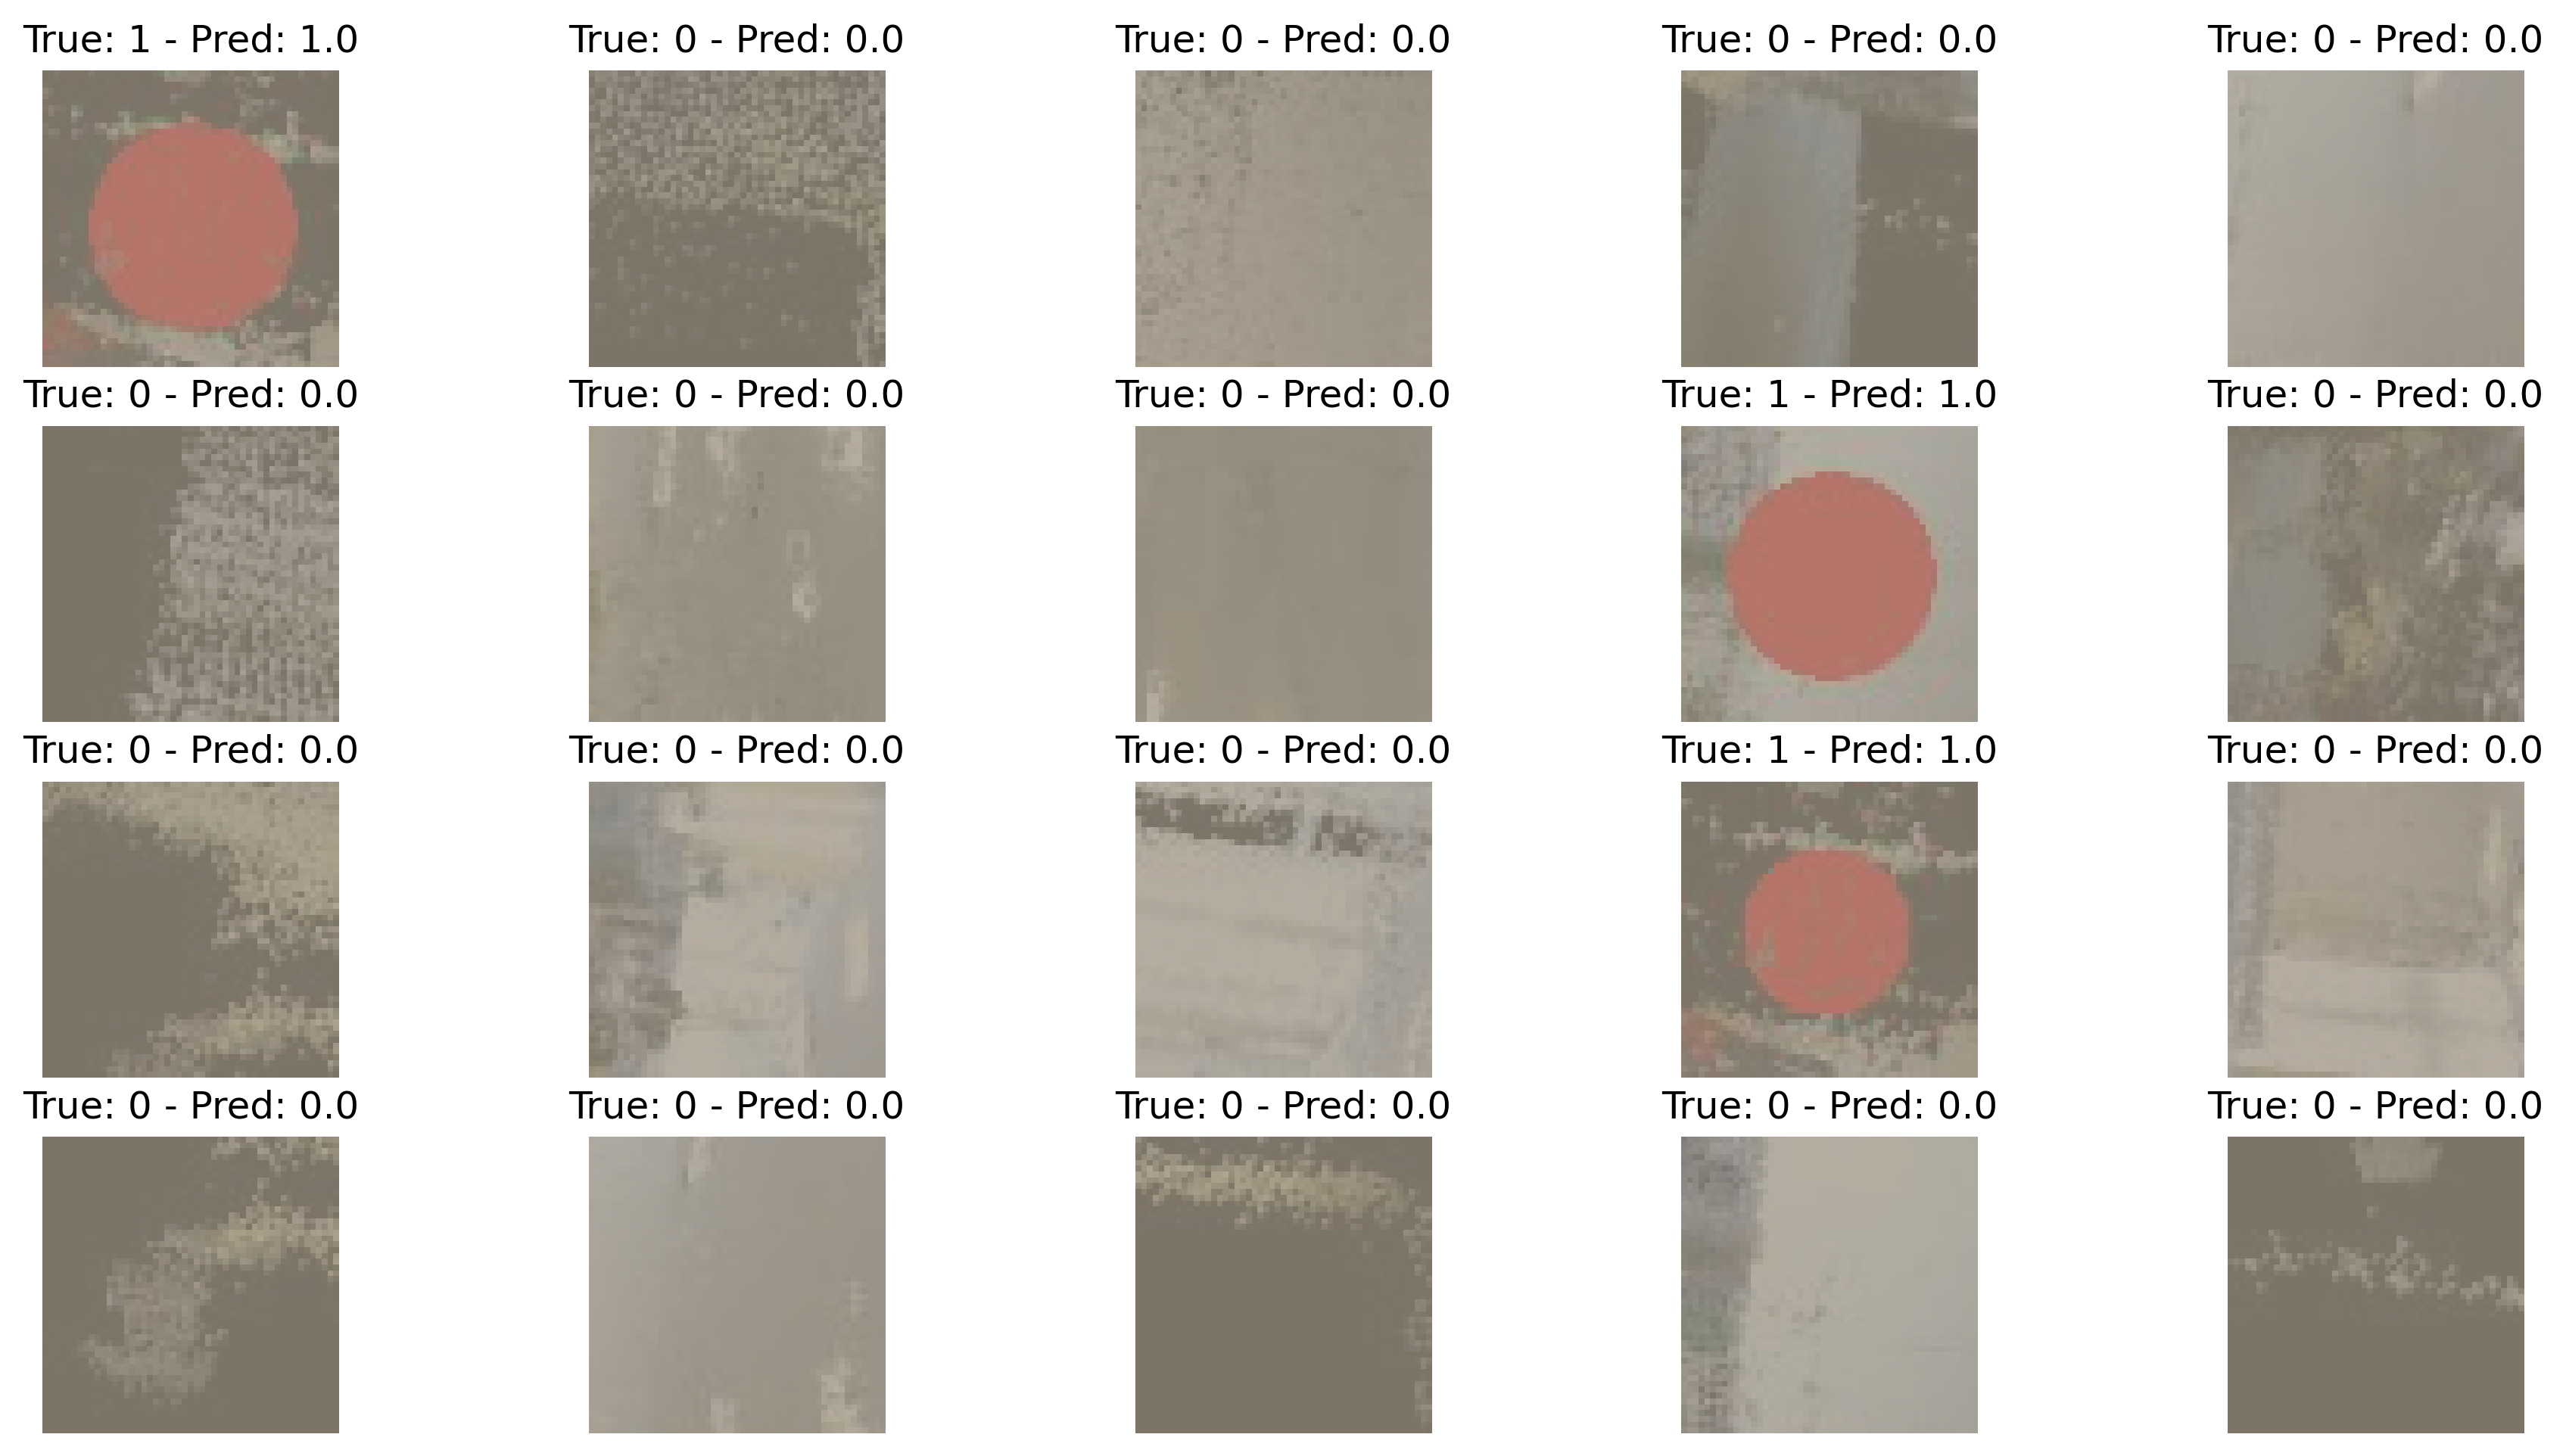

In [19]:
visualise_predictions(model, test_loader, num_images=20)

## Generate Training Data for Object DNN

In [7]:
model.load_state_dict(torch.load('models/CNN.pth')) # Load the trained model
model.eval() # Set evaluation mode
model.to(device) # Move the model to GPU

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [8]:
# Slide on a given image and extract the image block 
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[0], step_size): # Vertical direction
        for x in range(0, image.shape[1] - window_size[1], step_size): # Horizontal direction
            yield x, y, image[y:y+window_size[0], x:x+window_size[1]] # Get the image block

In [9]:
# Detection on the input image by means of a sliding window 
def detect_targets(image, model, window_size, step_size, threshold=0.5):
    target_mask = np.zeros_like(image[:, :, 0])  # Create a mask for targets
    transform = transforms.Compose([
        transforms.Resize((51, 51)),  # Resize the input window to 51x51 (just in case)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for x, y, window in sliding_window(image, step_size, window_size):
        window_uint8 = (window * 255).astype(np.uint8)  # Convert window to uint8
        window_image = Image.fromarray(window_uint8) # Convert uint8 format windows to PIL image objects 
        input_tensor = transform(window_image).unsqueeze(0).to(device) # Convert to tensor and move to GPU
        output = model(input_tensor) # Extracting scores from model outputs 
        score = output.item()

        if score >= threshold: # Check if the score is greater than or equal to the preset thresholds 
            target_mask[y:y+window_size[0], x:x+window_size[1]] = 1 # Marked as target present 

    return target_mask

In [20]:
# Get the map size
x_range, y_range, z_range = PacMan.calculate_pointcloud_bounds()
print("X Range:", x_range)
print("Y Range:", y_range)
print("Z Range:", z_range)

X Range: 17.798382
Y Range: 7.6320677
Z Range: 24.92617


In [21]:
# Define the range of positions and angles to traverse
map_size_x = int(x_range)
map_size_y = int(y_range)
map_size_z = int(z_range)

# Define the range of angles to traverse (reduced number of angles and larger step size)
angle_step = np.radians(90)  # 90 degrees step size
angles = np.arange(0, 2 * np.pi, angle_step)  # Angles from 0 to 360 degrees with 90 degrees step

In [24]:
# Save path
output_dir_positives = 'training_data/img/object_DNN/positives/'
output_dir_negatives = 'training_data/img/object_DNN/negatives/'

In [25]:
# Initialise Scene
global_cloud, spheres_collected = PacMan.startup_scene()

In [26]:
# x, y, z iterate over all possible positions in 3D space 
for x in range(map_size_x):
    for y in range(map_size_y):
        for z in range(map_size_z):
            position = np.array([x, y, z])
            for angle in angles:
                # Create rotation matrix from angle
                angle_rad = np.array([0, angle, 0]) # Rotate around the coordinate axis 
                image, _, _, _, _ = PacMan.project_pointcloud_image(global_cloud, angle_rad, position)
                
                # Detect targets in the image
                window_size = (51, 51) # Model's input size
                step_size = 5 # Adjust step size as needed
                target_mask = detect_targets(image, model, window_size, step_size) # Call the function
                
                # Save the png format image based on the presence of targets
                image_uint8 = (image * 255).astype(np.uint8)
                image_pil = Image.fromarray(image_uint8)
                
                if np.any(target_mask):
                    # Save the image in the positives directory if a target is detected
                    image_pil.save(os.path.join(output_dir_positives, f'image_pos_{position}_angle_{angle}.png'))
                else:
                    # Save the image in the negatives directory if no target is detected
                    image_pil.save(os.path.join(output_dir_negatives, f'image_pos_{position}_angle_{angle}.png'))